In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from numpy.fft import fft, ifft, fftfreq
from scipy import signal
from astropy.stats import LombScargle
from nfft import ndft, nfft, ndft_adjoint, nfft_adjoint
from gatspy.periodic import LombScargleFast
import time
import pdb
plt.style.use('seaborn')

In [9]:
def signal_no_equip(N, fixed=True):
    # 3 parts separated in time, one with slight irregularities in time sampling
    # another with change of spacing and the last one with big outlier in spacing
    T = np.zeros(N)
    dt_implicit = 1 / N
    t0 = np.linspace(0, 2*int(N/6)-1, 2*int(N/6))
    if fixed:
        np.random.seed(1)
    e = np.random.normal(0, dt_implicit * 0.5, 2*int(N/6))
    T[0:2*int(N/6)] = t0 * dt_implicit + e
    shift = 30 * dt_implicit
    
    if fixed:
        np.random.seed(2)
    t0 = np.linspace(2*int(N/6), 3*int(N/6)-1, int(N/6))
    e = np.random.normal(0, dt_implicit * 0.5, int(N/6))
    T[2*int(N/6):3*int(N/6)] = shift + t0 * dt_implicit / 2 + e
    
    if fixed:
        np.random.seed(3)
    t0 = np.linspace(3*int(N/6), 4*int(N/6)-1, int(N/6))
    e = np.random.normal(0, dt_implicit * 0.5, int(N/6))
    T[3*int(N/6):4*int(N/6)] = t0 * 2 * dt_implicit + e
    
    if fixed:
        np.random.seed(4)
    t0 = np.linspace(4*int(N/6), N-1, N - 4*int(N/6))
    e = np.random.normal(0, dt_implicit * 0.5, N - 4*int(N/6))
    T[4*int(N/6):N] = 2 * shift + t0 * dt_implicit / 2 + e
    T.sort()

    #  signal is sinusoidal again with same frequency
    temp = np.zeros(N)
    segment_duration = int(N/3)
    init = int(N/10)
    times_segment = T[init: init + segment_duration]
    times_segment = times_segment - min(times_segment)
    freq_sin = 2 / (max(times_segment) - min(times_segment))
#     print("choosen freq is: ", freq_sin)
    temp[init: init + segment_duration] = np.sin(freq_sin * 2 * np.pi * times_segment)
    return temp, freq_sin, T

def get_nfft(Nf, data, temp, t):
    dwindow = signal.tukey(len(temp), alpha=1./8)
    
    nfft_d = nfft_adjoint(t, dwindow * data, Nf)
    nfft_t = nfft_adjoint(t, dwindow * temp, Nf)
    k = -(Nf // 2) + np.arange(Nf)
    return nfft_d, nfft_t, k

11.64569958576624


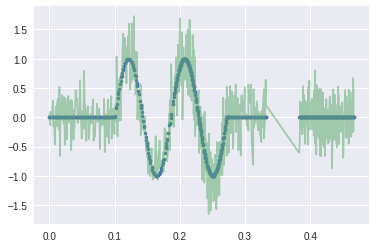

In [56]:
N = 1200
temp2, freq_sin, t2 = signal_no_equip(N, fixed=False)
print(freq_sin)
temp = temp2[:800]
t = t2[:800]
data = np.random.normal(0, 0.3, 800) + temp
N = 800
plt.plot(t, temp, '.')
plt.plot(t, data, alpha=0.5)

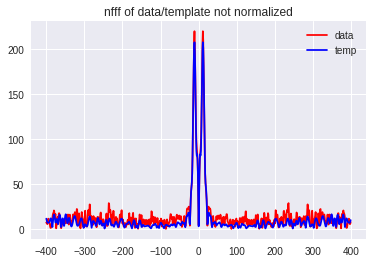

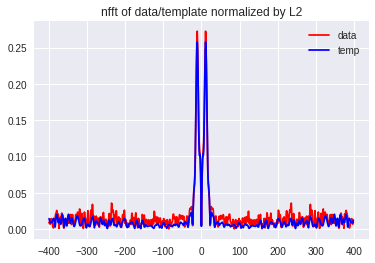

In [57]:
# get the nfft and normalize to unitary
nfft_d, nfft_t, k = get_nfft(N, data, temp, t)

## plot not normalized:
plt.figure()
plt.title("nfff of data/template not normalized")
plt.plot(k, np.abs(nfft_d), 'r', label='data')
plt.plot(k, np.abs(nfft_t), 'b', label='temp')
plt.legend()

## normalize for L2
norm = np.sqrt((np.abs(nfft_t)**2).sum())
nfft_d /= norm
nfft_t /= norm
plt.figure()
plt.title("nfft of data/template normalized by L2")
plt.plot(k, np.abs(nfft_d), 'r', label='data')
plt.plot(k, np.abs(nfft_t), 'b', label='temp')
plt.legend()

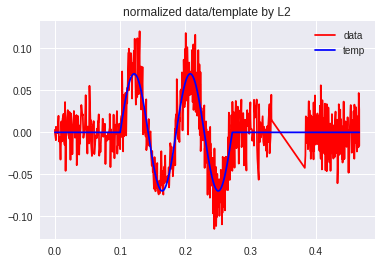

In [58]:
## normalize data to unity by L2
norm_data = np.sqrt((np.abs(temp)**2).sum())
data /= norm_data
temp /= norm_data

plt.figure()
plt.title("normalized data/template by L2")
plt.plot(t, data, 'r', label='data')
plt.plot(t, temp, 'b', label='temp')
plt.legend()

In [95]:
# check the parseval theorem for the inverse fourier transform
print(np.sum(np.abs(data)**2), np.sum(np.abs(nfft_d)**2))

1.3481045453719707 1.1319357502972136


In [141]:
## try doing the SNR with this normalization
def get_psd(k, t, data, min_freq=None, data_per_peak=1):
    df = 1 / ((max(t) - min(t)) * data_per_peak)
    if min_freq is None:
        min_freq = 0.5 * df
    NK = len(k)
    if NK % 2 == 0: # par
        N = int(NK / 2)
    else:
        N = int((NK-1) / 2)
    
    max_freq = (N - 1) * df + min_freq
    
    frequency, power = LombScargle(t, data).autopower(maximum_frequency=max_freq, minimum_frequency=min_freq,
                                                     samples_per_peak=data_per_peak)
    if len(frequency) != N:
        raise ValueError("algo malo")
    
    return frequency, power, df

def snr_no_equip(N, only_noise=False, fixed=False):
    temp, freq_sin, t = signal_no_equip(N, fixed=fixed)
    if only_noise:
        if fixed:
            np.random.seed(12312)
        data = np.random.normal(0, 0.3, N)
    else:
        data = np.random.normal(0, 0.3, N) + temp
        
    ## get the first 800 data generated
    temp = temp[:800]
    data = data[:800]
    t = t[:800]
    N = 800
    
    ## normalize the data/temp  by L2
    norm_data = np.sqrt((np.abs(temp)**2).sum())
    temp /= norm_data
    data /= norm_data
    
    # calcula la psd
    Nf = 4 * N
    k = -(Nf // 2) + np.arange(Nf)
    freqs, pw, df = get_psd(k, t, data)
    
    # repite la psd para obtener los datos con frequencias negativas, si Nf es par entonces el ultimo no se repite
    pw = np.append(pw, pw)
    if Nf % 2 == 0:
        pw = np.delete(pw, len(pw) - 1)
    
    nfft_d, nfft_t, k = get_nfft(Nf, data, temp, t)
    nfft_d = np.delete(nfft_d, 0) # remving the value corresponding to 0 frequency
    nfft_t = np.delete(nfft_t, 0)
    ## to get this as even remove another freq, for this time it will be the last one
    last_one = len(pw)-1
    nfft_d = np.delete(nfft_d, last_one)
    nfft_t = np.delete(nfft_t, last_one)
    pw = np.delete(pw, last_one)
    
    ## normaliza las nfft por L2
    norm_nfft = np.sqrt((np.abs(nfft_t)**2).sum())
    nfft_d /= norm_nfft
    nfft_t /= norm_nfft
    
    # check the parseval
    print("parseval theorem: ", np.sum(np.abs(data)**2), np.sum(np.abs(nfft_d)**2))
    
    norm_sigma = 4 * df
    h_norm = (nfft_t * nfft_t.conjugate() / pw).sum()
    norm_corr = 4 * df / np.sqrt(h_norm.real * norm_sigma)
    corr = nfft_d * nfft_t.conjugate() / pw / (2*Nf)
    inv_nfft = nfft(t, corr)
    
    # check parseval again
    print("parseval: ", np.sum(np.abs(data)**2), np.sum(np.abs(inv_nfft)**2))
    snr = inv_nfft * norm_corr * (max(t) - min(t)) * (len(nfft_d) - 1) / N
    snr = np.roll(snr, len(snr) // 2)
    return t, np.abs(snr), data, temp

parseval theorem:  1.4214088945383607 1.276431397544954
parseval:  1.4214088945383607 502.29821645828156


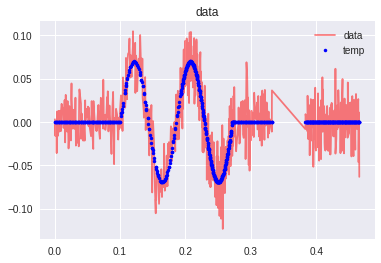

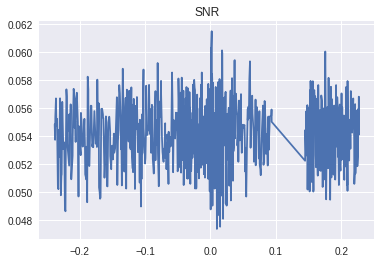

In [142]:
N = 1200
t, snr, data, temp = snr_no_equip(N, only_noise=False, fixed=False)
plt.figure()
plt.title("data")
plt.plot(t, data, 'r', alpha=0.5, label='data')
plt.plot(t, temp, 'b.', label='temp')
plt.legend()
plt.figure()
plt.title("SNR")
plt.plot(t-t[len(t)//2], snr)